In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2024-01-12 17:35:33.143782: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-12 17:35:33.728824: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
RESULTS_ROOT = "../01_simulation/04_results/"
SEEDS = ['42', '1234', '1867', '613', '1001']
#VEHICLE = "h3408c1:0"
#VEHICLE = "h482c1:0"
#VEHICLE = "h3120c1:0"
#VEHICLE = "h73c1:0"
VEHICLE = "carIn106:4"
TIME_WINDOW = 15*60 #seconds

In [4]:
global_model = tf.keras.models.load_model("saved_models/pretrained")

2024-01-12 17:35:34.317152: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-12 17:35:34.357550: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-12 17:35:34.358187: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
p_data = pd.DataFrame()
#READING DATA:
for s in SEEDS:
    filename = RESULTS_ROOT+f'poccup_by_vehs_{s}.csv'
    pf = pd.read_csv(filename)
    pf["seed"] = [s]*len(pf)
    p_data = pd.concat([p_data, pf])
    
parkings = p_data["parking_id"].unique()
true_parkings = p_data[p_data["veh_id"] == VEHICLE]["parking_id"].unique()
    
p_data = pd.get_dummies(p_data, columns=["parking_id"])
p_data["time"] = p_data["time"] - 4*24*60*60
p_data["time"] = p_data["time"].astype(int)
p_data["time_of_day"] = (p_data["time"] - (p_data["time"] // (24*60*60))*24*60*60) / (24*60*60) #converting to 0.0-1.0 and removing periodicity

In [6]:
vehicle_model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)
])

vehicle_model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(0.001))
vehicle_model.build(input_shape=(None,79))

In [7]:
vehicle_model.set_weights(global_model.get_weights())

In [8]:
p_train = p_data[p_data["veh_id"] == VEHICLE]
X_train = p_train.drop(columns=["veh_id", "time", "occupancy", "seed"])
y_train = p_train["occupancy"]

In [9]:
history = vehicle_model.fit(x=X_train, y=y_train, epochs=1, batch_size=10000)

2024-01-12 17:35:47.099415: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-12 17:35:47.129603: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9396cc8560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-12 17:35:47.129637: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-01-12 17:35:47.133381: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-12 17:35:47.164237: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-01-12 17:35:47.204848: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-12 17:

1/1 [==============================] - 1s 977ms/step - loss: 0.0016


In [10]:
def create_test_data(p_id, p_data):
    '''
        Creates test data for parking data for a complete day.
    '''
    parking_data = p_data[p_data[f"parking_id_{p_id}"] == 1]
    t = np.arange(0, 1, 1/(24*60*60))
    one_hot = parking_data.drop(columns=["veh_id", "time", "occupancy", "seed", "time_of_day"]).iloc[0]
    one_hot = [one_hot.values]*len(t)
    pred_x = np.array(one_hot)
    pred_x = pd.DataFrame(pred_x)
    pred_x["t"] = t
    return pred_x

In [11]:
p_diffs = {}

for p in parkings:
    test_data = create_test_data(p, p_data)
    pred_vehicle = vehicle_model.predict(test_data, batch_size=10000)
    pred_global  = global_model.predict(test_data, batch_size=10000)
    p_diffs[p] = (pred_vehicle-pred_global)**2

9/9 [==============================] - 0s 2ms/step


In [12]:
p_diff_means = {}
for p in parkings:
    p_diff_means[p] = np.mean(p_diffs[p])
    print(f"{p:30}: {np.mean(p_diffs[p]):6.4f}")

pa-27                         : 0.0019
pa-71                         : 0.0018
pa27                          : 0.0022
pa-3                          : 0.0028
pa3                           : 0.0020
pa-184                        : 0.0018
pa184                         : 0.0029
pa-172                        : 0.0028
pa172                         : 0.0044
pa-11                         : 0.0029
pa-outside2                   : 0.0024
pa11                          : 0.0017
pa-148                        : 0.0037
pa148                         : 0.0039
pa-164                        : 0.0026
pa-109                        : 0.0030
pa109                         : 0.0044
pa-152                        : 0.0036
pa152                         : 0.0043
pa-131                        : 0.0034
pa-central                    : 0.0019
pa-residential_east           : 0.0030
pa131                         : 0.0032
pa-123                        : 0.0047
pa-79                         : 0.0018
pa79                     

In [13]:
p_diff_series = pd.Series(p_diff_means)

In [14]:
predicted_ps = set(p_diff_series.nlargest(10).index)
true_parkings = set(true_parkings)
intersection = predicted_ps.intersection(true_parkings)
print(intersection, len(intersection))

{'pa-148', 'pa172', 'pa123', 'pa152', 'pa-123', 'pa148', 'pa196', 'pa144'} 8


In [15]:
time_diffs = {}
for p in parkings:
    for t in range(0, 24*60*60, TIME_WINDOW):
        if t in time_diffs:
            time_diffs[t] += np.mean(p_diffs[p][t:t+TIME_WINDOW])
        else:
            time_diffs[t] = np.mean(p_diffs[p][t:t+TIME_WINDOW])

In [16]:
time_diffs_series = pd.Series(time_diffs)

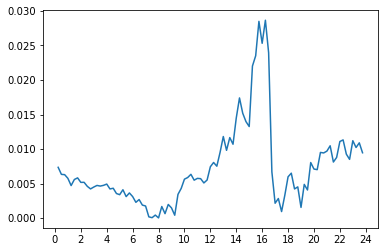

In [17]:
plot_res_x = np.arange(15*60, 24*60*60-15*60+1, TIME_WINDOW) #From 0:15 to 23:45, -1 seconds because of the differentiation
plot_res_y = np.abs(np.diff(time_diffs_series.values))#[15*60:-15*60]
plot_res = pd.Series(data=plot_res_y, index=plot_res_x)
plt.plot(plot_res_x/(60*60), plot_res_y)
plt.xticks(ticks=np.arange(0, 26, 2));

In [18]:
#print(f'{time_diffs_series.index[time_diffs_series.argmax()]//(60*60):2d}:{time_diffs_series.index[time_diffs_series.argmax()]%(60*60)//60:02d}')
print(f'{plot_res.index[plot_res.argmax()]//(60*60):2d}:{plot_res.index[plot_res.argmax()]%(60*60)//60:02d}')

16:15


In [19]:
pred_time = plot_res.index[plot_res.argmax()]/(24*60*60)
pred_time

0.6770833333333334

In [20]:
move_bins_counts, move_bins_bins = np.histogram(p_train["time_of_day"], bins=np.arange(0, 24*60*60, TIME_WINDOW)/(24*60*60))

In [21]:
def search_nearest_move_bin(pred_time, move_bins_counts, move_bins_bins):
    ref_idx, = np.where(move_bins_bins == pred_time)[0]
    rel_idx = 0
    #searching backward:
    while (ref_idx+rel_idx >= 0) and (move_bins_counts[ref_idx+rel_idx]==0):
        rel_idx -= 1
    down_step = 1
    if rel_idx<=0: #found some data
        down_step = rel_idx
    rel_idx = 0
    #searching forward:
    while (ref_idx+rel_idx < len(move_bins_counts)) and (move_bins_counts[ref_idx+rel_idx]==0):
        rel_idx += 1
    if rel_idx < (24*60*60)//TIME_WINDOW: #found some data
        if down_step == 1:
            return rel_idx
        else:
            return down_step if abs(down_step)<rel_idx else rel_idx
    else:
        return None if down_step == 1 else down_step

In [22]:
search_nearest_move_bin(pred_time, move_bins_counts, move_bins_bins)

7